In [5]:
import numpy as np
from select_lcss import LCSCandidate, Point
from matplotlib import pyplot as plt
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


In [15]:
def funkygibbons():
    q = np.load('lcss.npy')
    l = q[:30].copy()
    del q
    return l

def extract_stuff():
    LCSs = funkygibbons()
    x, y, z, triangs = [], [], [], []
    for l in LCSs:
        x.append(l.xs)
        y.append(l.ys)
        z.append(l.zs)
        triangs.append(l.triangulations)
    np.save('gx.npy',x)
    np.save('gy.npy',y)
    np.save('gz.npy',z)
    np.save('gt.npy',triangs)
    print('keklord')

In [16]:
extract_stuff()

keklord


<IPython.core.display.Javascript object>


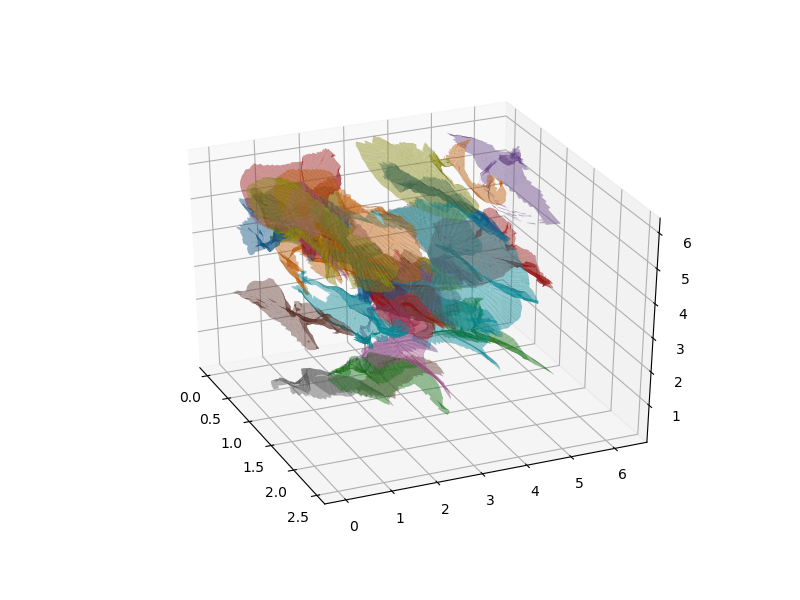

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for l in LCSs:
    ax.plot_trisurf(l.xs, l.ys, l.zs, triangles = l.triangulations,alpha=0.55)



IndexError: index 11 is out of bounds for axis 0 with size 10

In [12]:
np.shape(LCSs[0].triangulations)

(12571, 3)